## 导入数据，数据清洗

载入包文件

In [1]:
import pandas as pd
import numpy as np
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
# %load_ext scalene

载入数据

In [2]:
# 载入电影数据
data_item = pd.read_csv('../douban_movie/data/movies.csv')
print('电影数目：' ,data_item.shape[0])

电影数目： 2060


In [3]:
# 总评分最高的前10部电影
data_item.sort_values('rate', ascending=False)[['title','rate']].head(10)

,title,rate
1582,陈奕迅线上慈善演唱会 Live Is So Much Better With Music E...,9.7
1765,岚ARAFES2020at国立竞技场 ARASHI ARAFES 2020 at Natio...,9.6
1841,This is 嵐 LIVE,9.6
1071,宇多田光Laugher in the Dark 2018 巡回演唱会 Hikaru Utad...,9.5
1223,星野源巡回演唱会：流行病毒 GEN HOSHINO STADIUM TOUR “POP VI...,9.5
1919,山河令生来知己演唱会,9.5
1497,安德烈·波切利米兰大教堂空场独唱 Andrea Bocelli : Music for Ho...,9.4
1770,Funtastic Babii Fanmeeting,9.4
1807,TME Live 吴青峰「16叶」线上演唱会 TME Live 吳青峰「16葉」線上演唱會,9.4
1662,鱼丁糸Follow Me线上演唱会,9.4


In [4]:
def column_expand(data, column, list_values):
    for cl in list_values:
        tt = data_item[column].apply(lambda x: str(x)).str.contains('\W'+cl+'\W')
        uu = data_item[column].apply(lambda x: str(x)).str.contains('^'+cl+'$')
        ee = data_item[column].apply(lambda x: str(x)).str.contains(cl+'\s')
        ff = data_item[column].apply(lambda x: str(x)).str.contains('\s'+cl)
#         print('cl', cl)
#         print('tt', tt)
#         print('uu', uu)
#         print('ee', ee)
        cl_ = tt | uu| ee | ff
        cl_ *= 1
#         print('c1_', cl_)
        data['%s_%s' %(column ,cl)] = cl_
#         print('data', data)
        
class_movie = ['剧情','爱情','喜剧','科幻','动作','悬疑','犯罪','恐怖','青春'
               ,'励志','战争','文艺','黑色幽默','传记','情色','暴力','音乐','家庭']
country_movie = ['大陆','美国','香港','台湾','日本','韩国','英国','法国','德国','意大利','西班牙','印度','泰国','俄罗斯'
 ,'伊朗','加拿大','澳大利亚','爱尔兰','瑞典','巴西','丹麦']

def get_values_list(data, column, sep=None):
    Language_values=[]
    def countLANG(Languages):
        for language in Languages:
            language = language.strip()
            if language in Language_values: 
                continue
            else:
                Language_values.append(language)
    if sep:
        pd.DataFrame(data[column].str.split(sep))[column].apply(countLANG);
    else:
        data[column].apply(countLANG);
    return Language_values

def Paiming(data, column, list_values):
    column_expand(data, column, list_values)
    df = pd.DataFrame( 
        {'数目':[data['%s_%s' %(column, p)].sum() for p in list_values]}
        , index=list_values).sort_values('数目', ascending=False)
    return df

In [5]:
# 最受欢迎的电影类别排名
movie_type_list = Paiming(data_item, 'type', class_movie)
print(movie_type_list)
# 根据结果显示发现在2019-2021年三年的时间里爱情、科幻、悬疑、动作、喜剧 类型的电影，其中最受欢迎的是爱情题材的电影

       数目
爱情    139
科幻    138
悬疑    132
动作    129
喜剧    121
恐怖    108
剧情     68
音乐     44
家庭     44
传记     22
战争     17
犯罪     17
情色     11
青春      0
文艺      0
黑色幽默    0
暴力      0
励志      0


# 词云分析

In [6]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
from wordcloud import WordCloud # 词云包

In [7]:
def cut_word(content):
    # 导入、分词
    segment=[]
    for line in content: 
        try:
            segs = jieba.lcut(line) # jiaba.lcut() 
#             print(segs)
            for seg in segs:
                if len(seg)>1 and seg!='\r\n':
                    segment.append(seg)
        except:
            print(line)
            continue
#     print('cut_word', segment[:1000])
    return segment
cut_word(['阔别三十多年的同学，生活在不同的地方，有才华横溢事业有成的，有投资有方商海弄潮的，也有固守田园风光难舍故乡,真的好'])

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/jieba.cache
Loading model cost 0.348 seconds.
Prefix dict has been built successfully.


['阔别',
 '三十多年',
 '同学',
 '生活',
 '不同',
 '地方',
 '才华横溢',
 '事业有成',
 '投资',
 '有方',
 '商海',
 '弄潮',
 '固守',
 '田园风光',
 '难舍',
 '故乡',
 '真的']

In [8]:
def remove_stopword(segment):
    # 去停用词
    words_df = pd.DataFrame({'segment':segment})
    stopwords = pd.read_csv("../stopwords.txt" 
                          ,index_col=False
                          ,quoting=3
                          ,sep="\t"
                          ,names=['stopword']
                          ,encoding='utf-8') # quoting=3 全不引用    
    words_df=words_df[~words_df.segment.isin(stopwords.stopword)]
    return words_df

In [9]:
# 统计词频
def get_word_count(words_df):
    words_stat = words_df.groupby('segment').agg(计数=pd.NamedAgg(column='segment', aggfunc='size')).reset_index().sort_values(by='计数', ascending=False)
    return words_stat

In [10]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
def createHist(x_data):
#     ax1.hist(x_data, histtype='stepfilled', bins=200, color = y1_color)
    plt.bar(x_width,y_data,lw=0.5,fc="r",width=0.3,label="Phone")
    ax1.set_title(title)
    plt.ylabel('Number')
    plt.xlabel('High frequency words of each movie')

In [11]:
# 词云展示
import imageio
matplotlib.rcParams['figure.figsize']=(10.0,10.0)
from wordcloud import WordCloud,ImageColorGenerator
def createWordCloud(imgPath, words_stat={}):
    bimg=imageio.imread('cover.jpg')
    wordcloud=WordCloud(background_color="white",mask=bimg,font_path='../simhei.ttf',max_font_size=200)
    word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
    wordcloud=wordcloud.fit_words(word_frequence)
    bimgColors=ImageColorGenerator(bimg)
    plt.axis("off")
    plt.imshow(wordcloud.recolor(color_func=bimgColors))

In [12]:
def createWordCloudByGenre(content, imgPath='cover.jpg'):
    segment = cut_word(content)
#     print('segment', segment)
#     segment = tf_idf_words(segment)
#     print('segment', segment)
    words_df = remove_stopword(segment)
    words_stat = get_word_count(words_df)
    createWordCloud(imgPath,words_stat=words_stat)

In [13]:
# 读取影评数据集
data_com = pd.read_csv('../douban_movie/data/comment.csv')

In [14]:
# 合并电影短评
movie_comment_data = pd.merge(data_item, data_com, on="movie_id")

In [15]:
# 对最受欢迎的前五条电影类别进行分析
movie_top_five = movie_type_list.head(5).index
# movie_type={x: x.index for x in movie_type_list}
# print(movie_type)
# # 获取方式某个题材的影评
def get_comment(type):
    flag = movie_comment_data['type'].apply(lambda x: str(x)).str.contains(type)
    content = movie_comment_data[flag].content
    return content

In [16]:
comment = get_comment('爱情').values.tolist()

In [17]:
segment = cut_word(comment)
words_df = remove_stopword(segment)
words_stat = get_word_count(words_df).head(10)
print(words_stat)

nan
      segment    计数
38113      故事  4301
22459      喜欢  2864
28648      导演  2595
26113      女主  1784
46471      演员  1745
46536      演技  1662
49637      男主  1650
9542       不错  1490
26679      好看  1454
59741      角色  1431


nan


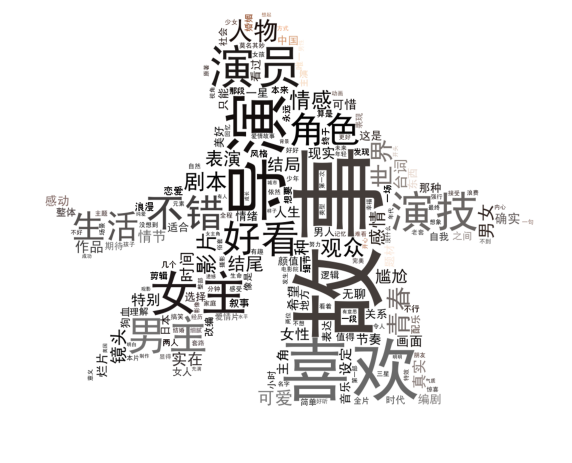

In [18]:
# 词云展示最受欢迎的五个类型评论

createWordCloudByGenre(comment)

      segment    计数
32236      故事  3152
44379      科幻  1710
10505      人类  1602
8192       不错  1589
24132      导演  1575
50880      设定  1539
40551      特效  1435
8310       世界  1307
19003      喜欢  1231
50408      角色  1002


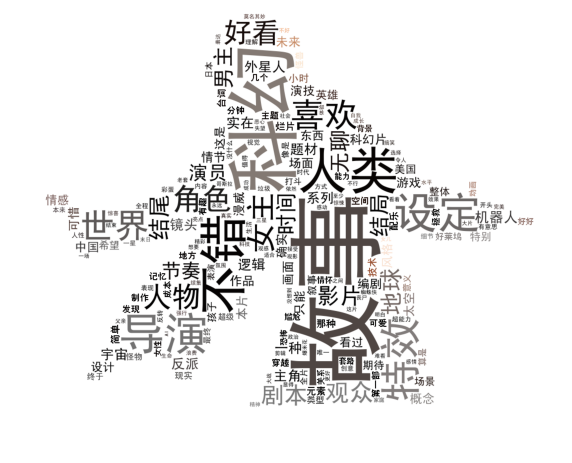

In [19]:
comment = get_comment('科幻').values.tolist()
segment = cut_word(comment)
words_df = remove_stopword(segment)
words_stat = get_word_count(words_df).head(10)
print(words_stat)
createWordCloudByGenre(comment)

      segment    计数
30281      故事  3705
22192      导演  2152
6382       不错  1786
37294      演技  1403
37262      演员  1311
48172      角色  1248
17145      喜欢  1174
26237      悬疑  1102
20231      女主  1089
46369      节奏  1061


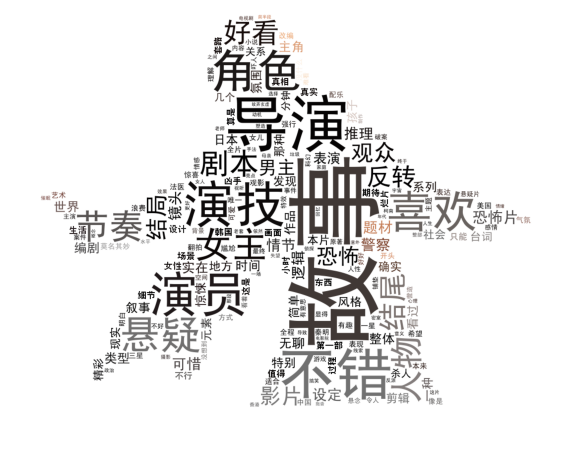

In [20]:
comment = get_comment('悬疑').values.tolist()
segment = cut_word(comment)
words_df = remove_stopword(segment)
words_stat = get_word_count(words_df).head(10)
print(words_stat)
createWordCloudByGenre(comment)

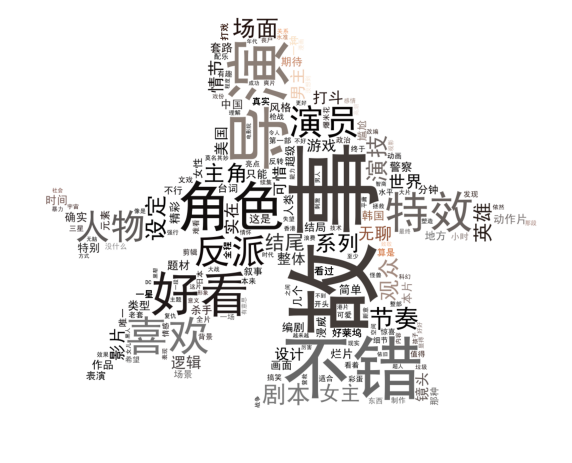

In [21]:
comment = get_comment('动作').values.tolist()
createWordCloudByGenre(comment)

      segment    计数
42405      故事  4499
25655      喜欢  2746
32211      导演  2273
11994      不错  2010
23685      可爱  1941
65557      角色  1803
51201      演员  1733
30180      好看  1718
41655      搞笑  1369
51261      演技  1353


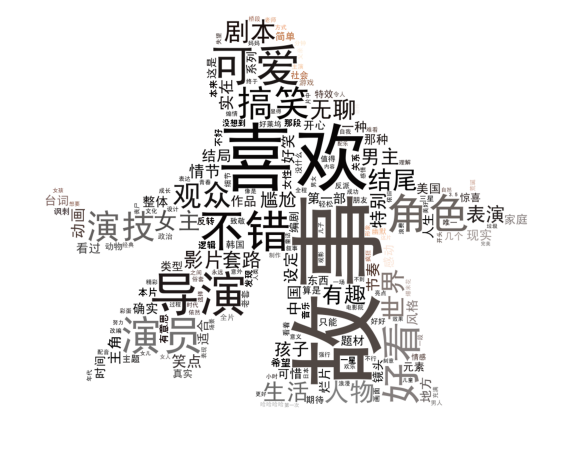

In [22]:
comment = get_comment('喜剧').values.tolist()
segment = cut_word(comment)
words_df = remove_stopword(segment)
words_stat = get_word_count(words_df).head(10)
print(words_stat)
createWordCloudByGenre(comment)

## 2.情感分析

In [23]:
# from snownlp import SnowNLP
# # 读取评论数据
# df = pd.read_csv('../douban_movie/data/comment.csv')
# df = df.dropna(subset=['content'])
# df['segments'] = df['content'].apply(lambda x: (SnowNLP(x).sentiments))
# # df['segments'] = df['content'].apply(lambda x: print(x))
# # print(df['segments'])
# # print(SnowNLP('asdad').sentiments)

In [24]:
# df.to_csv('comment-segments.csv')

In [25]:
df = pd.read_csv('../douban_movie/data/comment-segments.csv')
df = pd.merge(data_item, df, on="movie_id")
print(len(df['id']))
def getRate(df,type):
    positive = ['力荐', '推荐']
    middle = ['还行']
    negative = ['较差', '很差']
    praise_flag = df['degree'].apply(lambda x: x in positive)
    middle_flag = df['degree'].apply(lambda x: x in middle)
    negative_flag = df['degree'].apply(lambda x: x in negative)
    number_of_praise = len(df[praise_flag])
    number_of_middle = len(df[middle_flag])
    number_of_negative = len(df[negative_flag])
    total = len(df['id'])
    print('-----------{type}---------'.format(type=type))
    print('total', total)
    print('好评', number_of_praise)
    print('差评', number_of_negative)
    print('中评', number_of_middle)
    print('好评率', number_of_praise/total)
    print('差评率', number_of_negative/total)
    print('中评率', number_of_middle/total)

202245


In [26]:
# 好评率
movie_top_five = movie_type_list.head(5).index.values.tolist()
print(movie_top_five)
for type in movie_top_five:
    flag = df['type'].apply(lambda x: str(x)).str.contains(type)
    df_by_type = df[flag]
    getRate(df_by_type, type)

['爱情', '科幻', '悬疑', '动作', '喜剧']
-----------爱情---------
total 34726
好评 10278
差评 12627
中评 10532
好评率 0.29597419800725683
差评率 0.36361803835742673
中评率 0.30328860220008064
-----------科幻---------
total 28178
好评 7206
差评 10741
中评 9356
好评率 0.2557314216764852
差评率 0.3811839023351551
中评率 0.3320320817659167
-----------悬疑---------
total 28378
好评 6300
差评 10353
中评 10789
好评率 0.2220029600394672
差评率 0.36482486433152445
中评率 0.380188878708859
-----------动作---------
total 44906
好评 11121
差评 16775
中评 15801
好评率 0.2476506480203091
差评率 0.37355809914042665
中评率 0.35186834721418075
-----------喜剧---------
total 43823
好评 13487
差评 13613
中评 15299
好评率 0.30776076489514637
差评率 0.31063596741437144
中评率 0.34910891540971634


## 3.主题分析

In [27]:
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
 
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [28]:
# 数据处理
content_by_type = {}
for type in movie_top_five:
    flag = df['type'].apply(lambda x: str(x)).str.contains(type)
    content = df[flag].content.values.tolist()
    content_by_type[type] = content
# print(content_by_type['爱情'][:100])

In [29]:
import jieba.analyse
# 构建词典
data_set = []
content_X = content_by_type['爱情']
for content in content_X:
    segment = []
#     jieba.analyse.set_stop_words('../customer-stopword.txt')
    segs = jieba.analyse.extract_tags(content, topK=20, allowPOS=('n'), withWeight=False)
#     segs = jieba.lcut(content)
    stopwords = pd.read_csv("../stopwords.txt" 
                              ,index_col=False
                              ,quoting=3
                              ,sep="\t"
                              ,names=['stopword']
                              ,encoding='utf-8') # quoting=3 全不引用 
    for seg in segs:
        if len(seg)>1 and seg!='\r\n' and seg not in stopwords.stopword.values.tolist():
            segment.append(seg)
    data_set.append(segment)
print(data_set[:100])
dictionary = corpora.Dictionary(data_set)  # 构建词典
# print(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in data_set]
# print(corpus)

[['情伤', '头毛', '外形', '角色', '习惯'], ['男主', '女主', '工天造地', '灰姑娘', '女佣', '水管', '贵族'], ['贵气', '大户人家', '气息', '演员', '男女'], ['管家', '优点'], ['异性恋', '内心'], ['老版', '女管家', '彩色片', '剧透', '共情', '压迫感', '葬身', '光色', '故事情节', '女主人', '纯属', '噩梦', '舆论', '无力', '案件', '过度', '权利', '环境', '机会', '利用'], ['选角', '沙包', '西装', '风情', '管家', '夫人', '男人', '程度'], ['海报', '红军', '脑袋'], ['结尾', '音效', '老版', '亏本生意', '叙构', '原版', '原汁原味', '剪辑', '新意', '情节', '技巧', '经典', '逻辑', '语言', '故事', '基础'], [], ['太帅', '男主'], ['悬疑片', '鬼片', '灰姑娘', '女神', '角色', '总体', '声音', '空间'], ['环游世界', '加场', '白眼', '视角', '结尾', '氛围', '管家', '眼神', '细节', '男女', '故事', '工具'], ['氛围', '感情'], ['女管家', '屌丝', '灰姑娘', '恶毒', '豪门', '故事', '强势'], ['全片', '氛围'], ['看片', '勿近', '贵气', '杂念', '阳气', '气质', '脑子里', '眼神', '故事', '世纪'], ['试镜', '洗心革面', '情爱', '胜任', '寓言', '标签', '色调', '性感', '动人', '主角', '角色', '全是', '男女', '想象', '消失', '证明', '身体'], ['家暴', '女特务'], ['探案', '老版'], ['女主', '一张白纸', '原著', '衬托', '相貌', '行事', '技巧', '性格', '小说', '关系', '社会'], ['锤子', '全片', '表情', '下基层', '演技', '富家', '大法', '油腻', '煤老板', '体态', '睁开', 

In [30]:
# 构建LDA模型
import pprint
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import gensim
num_topics = 8
# 传统lda词袋30
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)   #分为5个主题,text:文本，已经表示成词袋了。num_topics: 提取的主题数id2word:词典passes:类似于在机器学习中常见的epoch，也就是训练了多少轮;random_state -这是一个种子（如果您想精确地重复训练过程）。
# pprint.pprint(ldamodel.print_topics(num_topics=num_topics, num_words=15))  #每个主题输出5个单词

#LdaMallet模型 50
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=dictionary)
pprint.pprint(ldamallet.show_topics(formatted=False))

# tfidf 47
# tfidf = gensim.models.TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)   #分为5个主题,text:文本，已经表示成词袋了。num_topics: 提取的主题数id2word:词典passes:类似于在机器学习中常见的epoch，也就是训练了多少轮;random_state -这是一个种子（如果您想精确地重复训练过程）。
# pprint.pprint(ldamodel.print_topics(num_topics=num_topics, num_words=15))  #每个主题输出5个单词


# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_set, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


ModuleNotFoundError: No module named 'gensim.models.wrappers'

In [ ]:
#计算困惑度
def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)
#计算coherence
def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
    ldacm = CoherenceModel(model=ldamodel, texts=data_set, dictionary=dictionary, coherence='c_v')
#     print(ldacm.get_coherence())
    return ldacm.get_coherence()

In [ ]:
# 绘制主题-coherence曲线，选择最佳主题数
x = range(1,15)
y = [perplexity(i) for i in x]  #如果想用困惑度就选这个
# y = [coherence(i) for i in x]
plt.plot(x, y)
plt.xlabel('主题数目')
plt.ylabel('coherence大小')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('主题-coherence变化情况')
plt.show()

In [ ]:
#  通过上述主题评估，我们发现可以选择3作为主题个数，接下来我们可以再跑一次模型，设定主题数为5，并输出每个文档最有可能对应的主题
from gensim.models import LdaModel
import pandas as pd
from gensim.corpora import Dictionary
from gensim import corpora, models

 
dictionary = corpora.Dictionary(data_set)  # 构建词典
corpus = [dictionary.doc2bow(text) for text in data_set]
 
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, passes = 30,random_state=1)
topic_list=lda.print_topics()
pprint.pprint(topic_list)
for i in lda.get_document_topics(corpus)[:]:
    print('i==',i)
    listj=[]
    for j in i:
        print('j==', j)
        listj.append(j[1])
#     print(listj)
    bz=listj.index(max(listj))
#     print(i[bz][0])

# for topic in lda.print_topics(num_words = 20):
#     termNumber = topic[0]
#     print(topic[0], ':', sep='')
#     listOfTerms = topic[1].split('+')
#     for term in listOfTerms:
#         listItems = term.split('*')
#         print('  ', listItems[1], '(', listItems[0], ')', sep='')

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
# 用pyLDAvis将LDA模式可视化
plot =pyLDAvis.gensim_models.prepare(lda,corpus,dictionary)
# pyLDAvis.show(plot)
# 保存到本地html
pyLDAvis.save_html(plot, 'pyLDAvis.html')
